In [3]:
pip install torch-xla[tpu] -f https://storage.googleapis.com/libtorch-xla-releases/index.html

Looking in links: https://storage.googleapis.com/libtorch-xla-releases/index.html


In [1]:
!pip freeze > dependencias_colab.txt
from google.colab import files
files.download("dependencias_colab.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["PJRT_DEVICE"] = "TPU"
import json
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

# Cargar datos
ruta_archivo = "/content/drive/My Drive/Vida privada/MAESTRIA/TESIS/datos_codificados_sentimientos.json"
modelo_guardado = "/content/drive/My Drive/Vida privada/MAESTRIA/TESIS/modelo_xlm_roberta_sentimientos"

if not os.path.exists(ruta_archivo):
    raise FileNotFoundError(f"No se encontró el archivo en {ruta_archivo}")

with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
    datos_codificados_sentimientos = json.load(archivo)

# Preparar datos
textos = [d["publicacion"] for d in datos_codificados_sentimientos]
etiquetas = [d["sentimiento"] + 1 for d in datos_codificados_sentimientos]  # Ajuste para evitar índices negativos

# División en entrenamiento y validación
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    textos, etiquetas, test_size=0.2, random_state=42
)

# Tokenización
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
tokenizer = AutoTokenizer.from_pretrained(model_path)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Crear dataset
class SentimientosDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_dataset = SentimientosDataset(train_encodings, train_labels)
val_dataset = SentimientosDataset(val_encodings, val_labels)

# Función de entrenamiento y evaluación con TPU
def _mp_fn(rank):
    device = xm.xla_device()
    print(f"Proceso {rank}: Dispositivo asignado -> {device}")

    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
    model.to(device, dtype=torch.bfloat16)

    # Activar gradient checkpointing si está disponible
    #if hasattr(model, "gradient_checkpointing_enable"):
        #model.gradient_checkpointing_enable()

    # Configurar DataLoader optimizado para TPU
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3
    )

    def train_epoch():
        model.train()
        total_loss = 0
        parallel_loader = pl.MpDeviceLoader(train_loader, device)

        for step, batch in enumerate(parallel_loader):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()

            xm.optimizer_step(optimizer)
            xm.mark_step()

            if step % 50 == 0:
                xm.master_print(f"Proceso {rank} - Epoch progreso: {step}/{len(train_loader)}")

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def evaluate():
        model.eval()
        predictions, true_labels = [], []
        total_loss = 0
        parallel_loader = pl.MpDeviceLoader(val_loader, device)

        with torch.no_grad():
            for batch in parallel_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                logits = outputs.logits
                total_loss += outputs.loss.item()

                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())

        from sklearn.metrics import accuracy_score, classification_report
        accuracy = accuracy_score(true_labels, predictions)
        xm.master_print(classification_report(true_labels, predictions, labels=[0, 1, 2], target_names=["Negativo", "Neutral", "Positivo"]))
        return total_loss / len(val_loader), accuracy

    epochs = 10
    for epoch in range(epochs):
        xm.master_print(f"Proceso {rank} - Epoch {epoch + 1}/{epochs} iniciada...")
        train_loss = train_epoch()
        val_loss, val_accuracy = evaluate()
        xm.master_print(f"Proceso {rank} - Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    if rank == 0:
        model.to("cpu")
        model.save_pretrained(modelo_guardado)
        tokenizer.save_pretrained(modelo_guardado)
        xm.master_print(f"Modelo guardado en {modelo_guardado}")

if __name__ == "__main__":
    xmp.spawn(_mp_fn, args=(), nprocs=1)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Proceso 0: Dispositivo asignado -> xla:0


config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Proceso 0 - Epoch 1/10 iniciada...
Proceso 0 - Epoch progreso: 0/48
              precision    recall  f1-score   support

    Negativo       0.88      0.97      0.92        88
     Neutral       0.99      0.96      0.97       292
    Positivo       1.00      1.00      1.00         2

    accuracy                           0.96       382
   macro avg       0.96      0.97      0.96       382
weighted avg       0.96      0.96      0.96       382

Proceso 0 - Epoch 1/10 | Train Loss: 0.2076 | Validation Loss: 0.1247 | Validation Accuracy: 0.9607
Proceso 0 - Epoch 2/10 iniciada...
Proceso 0 - Epoch progreso: 0/48
              precision    recall  f1-score   support

    Negativo       0.70      1.00      0.82        88
     Neutral       1.00      0.87      0.93       292
    Positivo       1.00      1.00      1.00         2

    accuracy                           0.90       382
   macro avg       0.90      0.96      0.92       382
weighted avg       0.93      0.90      0.91       382

Pr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TPU configurada en: xla:0
Datos cargados correctamente.
Iniciando evaluación del modelo con datos de validación.
Precisión en validación: 0.9084
Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.72      0.98      0.83        88
     Neutral       0.99      0.89      0.94       292
    Positivo       1.00      1.00      1.00         2

    accuracy                           0.91       382
   macro avg       0.91      0.95      0.92       382
weighted avg       0.93      0.91      0.91       382



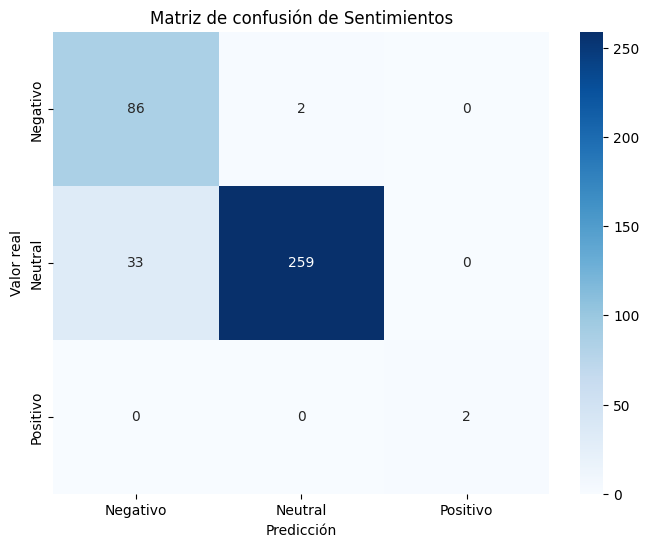

Matriz de confusión guardada en /content/drive/My Drive/Vida privada/MAESTRIA/TESIS/confusion_matrix_sentimientos.png.


In [2]:
# Paso 1: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importar librerías necesarias
import os
import json
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 2: Configurar TPU
device = xm.xla_device()
print("TPU configurada en:", device)

# Paso 3: Definir rutas en Google Drive
modelo_dir = "/content/drive/My Drive/Vida privada/MAESTRIA/TESIS/modelo_xlm_roberta_sentimientos"
ruta_archivo = "/content/drive/My Drive/Vida privada/MAESTRIA/TESIS/datos_codificados_sentimientos.json"
ruta_guardado_matriz = "/content/drive/My Drive/Vida privada/MAESTRIA/TESIS/confusion_matrix_sentimientos.png"

# Verificar si el archivo de datos existe antes de leerlo
if os.path.exists(ruta_archivo):
    with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
        datos_codificados = json.load(archivo)
    print("Datos cargados correctamente.")
else:
    raise FileNotFoundError(f"No se encontró el archivo en {ruta_archivo}. Verifica la ubicación.")

# Paso 4: Cargar modelo y tokenizer
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(modelo_dir)
model.to(device)

# Paso 5: Preparar los datos (Asegurar que solo se use el conjunto de validación)
textos = [d["publicacion"] for d in datos_codificados]
etiquetas = [d["sentimiento"] + 1 for d in datos_codificados]  # Ajuste para evitar índices negativos

# Dividir los datos en entrenamiento y validación (manteniendo 80% train, 20% test)
_, val_texts, _, val_labels = train_test_split(textos, etiquetas, test_size=0.2, random_state=42)

# Tokenizar solo los datos de validación
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class SentimientosDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Crear dataset y dataloader solo con datos de validación
val_dataset = SentimientosDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2)

# Función de evaluación
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return accuracy_score(true_labels, predictions), true_labels, predictions

# Evaluación del modelo con datos de validación
print("Iniciando evaluación del modelo con datos de validación.")
accuracy, true_labels, predictions = evaluate(model, val_loader, device)
print(f"Precisión en validación: {accuracy:.4f}")

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(true_labels, predictions, labels=[0, 1, 2], target_names=["Negativo", "Neutral", "Positivo"]))

# Generar y guardar matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Neutral", "Positivo"], yticklabels=["Negativo", "Neutral", "Positivo"])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión de Sentimientos')

# Guardar la matriz en Google Drive
plt.savefig(ruta_guardado_matriz)
plt.show()
print(f"Matriz de confusión guardada en {ruta_guardado_matriz}.")
